Using gpu device 0: GRID K520


In [1]:
%matplotlib inline
import time
import pylab as pl
from IPython import display

from  pylearn2.train_extensions.live_monitoring import *


import copy
from IPython import display

try:
    import zmq
    zmq_available = True
except:
    zmq_available = False

try:
    import matplotlib.pyplot as plt
    pyplot_available = True
except:
    pyplot_available = False

from functools import wraps
from pylearn2.monitor import Monitor
from pylearn2.train_extensions import TrainExtension

class LiveMonitor(object):

    def __init__(self, address='127.0.0.1', req_port=5555):
        """
        """
        if not zmq_available:
            raise ImportError('zeromq needs to be installed to '
                              'use this module.')

        self.address = 'tcp://%s' % address

        assert(req_port > 0)
        self.req_port = req_port

        self.context = zmq.Context()

        self.req_sock = self.context.socket(zmq.REQ)
        self.req_sock.connect(self.address + ':' + str(self.req_port))

        self.channels = {}

    def list_channels(self):
        """
        Returns a list of the channels being monitored.
        """
        self.req_sock.send_pyobj(ChannelListRequest())
        return self.req_sock.recv_pyobj()

    def update_channels(self, channel_list, start=-1, end=-1, step=1):
       
        assert((start == -1 and end == -1) or end > start)

        if start == -1:
            start = 0
            if len(self.channels.keys()) > 0:
                channel_name = list(self.channels.keys())[0]
                start = len(self.channels[channel_name].epoch_record)

        self.req_sock.send_pyobj(ChannelsRequest(
            channel_list, start=start, end=end, step=step
        ))

        rsp_msg = self.req_sock.recv_pyobj()

        if isinstance(rsp_msg.data, Exception):
            raise rsp_msg.data

        for channel in rsp_msg.data.keys():
            rsp_chan = rsp_msg.data[channel]

            if isinstance(rsp_chan, Exception):
                raise rsp_chan

            if channel not in self.channels.keys():
                self.channels[channel] = rsp_chan
            else:
                chan = self.channels[channel]
                chan.batch_record += rsp_chan.batch_record
                chan.epoch_record += rsp_chan.epoch_record
                chan.example_record += rsp_chan.example_record
                chan.time_record += rsp_chan.time_record
                chan.val_record += rsp_chan.val_record

    def follow_channels(self, channel_list):
        
        if not pyplot_available:
            raise ImportError('pyplot needs to be installed for '
                              'this functionality.')
        plt.clf()
        plt.ion()
        while True:
            self.update_channels(channel_list)
            plt.clf()
            for channel_name in self.channels:
                #print channel_name
                #print self.channels[channel_name].epoch_record
                plt.plot(
                    self.channels[channel_name].epoch_record,
                    self.channels[channel_name].val_record,
                    label=channel_name
                )
            plt.legend()
            
            plt.minorticks_on()
            
            ax = plt.axes()
            ax.yaxis.grid(True)
            ax.set_yscale('log')
            #plt.grid(b=True, which='major', color='b', linestyle='-')
            #plt.grid(b=True, which='minor', color='black', linestyle='--')
            
            plt.ion()
            #plt.draw()
            display.clear_output(wait=True)
            display.display(plt.gcf())
    def get_values(self, channel_name):
        return self.channels[channel_name].val_record
        

Using gpu device 0: GRID K520


In [3]:
lm = LiveMonitor()
print lm.list_channels().data

['train_objective', 'train_h1_min_x_min_u', 'train_h1_max_x_max_u', 'train_h1_row_norms_min', 'train_y_range_x_min_u', 'train_h1_max_x_mean_u', 'train_h1_min_x_mean_u', 'train_h1_range_x_max_u', 'train_y_max_x_min_u', 'train_y_row_norms_max', 'train_h1_mean_x_max_u', 'train_h1_col_norms_mean', 'train_h1_mean_x_mean_u', 'train_h0_row_norms_mean', 'train_h0_col_norms_max', 'train_h1_range_x_min_u', 'train_y_col_norms_max', 'train_h0_mean_x_min_u', 'train_y_col_norms_mean', 'train_y_min_x_max_u', 'train_h0_col_norms_mean', 'train_y_min_x_min_u', 'train_h1_col_norms_min', 'train_h0_row_norms_max', 'train_h1_row_norms_max', 'train_y_col_norms_min', 'train_h0_col_norms_min', 'train_y_max_x_max_u', 'train_y_mean_x_min_u', 'train_h0_range_x_min_u', 'train_h0_min_x_mean_u', 'train_h1_max_x_min_u', 'train_h0_mean_x_max_u', 'train_h1_col_norms_max', 'train_h0_range_x_mean_u', 'train_y_mean_x_max_u', 'train_h1_min_x_max_u', 'train_h1_range_x_mean_u', 'train_h0_range_x_max_u', 'train_h0_row_norms_m

In [12]:
lm.req_sock.close()

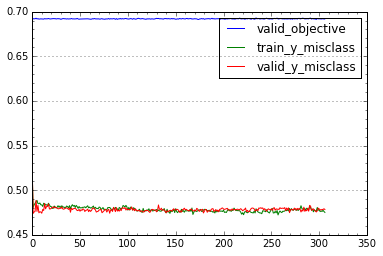

KeyboardInterrupt: 

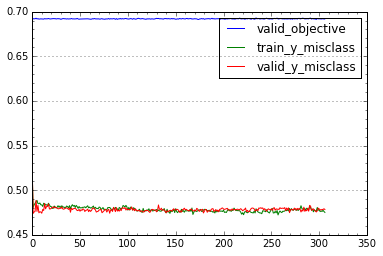

In [99]:
lm = LiveMonitor()
lm.follow_channels(['valid_objective', "valid_y_misclass", "train_y_misclass"])

In [9]:
lm.get_values("valid_y_misclass")[-1]

array(0.48164671659469604, dtype=float32)

In [45]:
lm.get_values("train_objective")

[array(1.343436792922148e-06, dtype=float32),
 array(1.3431985053102835e-06, dtype=float32),
 array(1.3428494867184781e-06, dtype=float32),
 array(1.3426728173726588e-06, dtype=float32),
 array(1.3423344853435992e-06, dtype=float32),
 array(1.342231257694948e-06, dtype=float32),
 array(1.3421074527286692e-06, dtype=float32),
 array(1.342004225080018e-06, dtype=float32),
 array(1.341944539490214e-06, dtype=float32),
 array(1.3418692788036424e-06, dtype=float32),
 array(1.3418027720035752e-06, dtype=float32),
 array(1.3416226920526242e-06, dtype=float32),
 array(1.3415567536867457e-06, dtype=float32),
 array(1.3413955457508564e-06, dtype=float32),
 array(1.3413318811217323e-06, dtype=float32),
 array(1.3412823136604857e-06, dtype=float32),
 array(1.341211941507936e-06, dtype=float32),
 array(1.3411658983386587e-06, dtype=float32),
 array(1.3411328154688817e-06, dtype=float32),
 array(1.3410660812951392e-06, dtype=float32),
 array(1.3410817700787447e-06, dtype=float32),
 array(1.340986045

KeyboardInterrupt: 

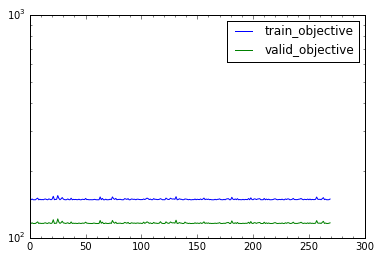

In [49]:
lm = LiveMonitor()
lm.follow_channels(["train_objective", "valid_objective"])